# Disease Outbreak Predictor
Course: CPE 3018 – Numerical Methods
Project: Data-Driven Disease Outbreak Predictor
Language: Python (Jupyter Notebook)

Overview
This notebook implements a disease outbreak predictor based on Newton's Divided Difference Method. It:
1. Uses a small number of time-based data points (days vs. cases/deaths).
2. Builds an interpolating polynomial using divided differences.
3. Performs:
 - Interpolation (estimating missing data within the time range).
 - Extrapolation (estimating future cases beyond the time range).
4. Applies error analysis concepts from Numerical Methods:
 - Absolute and relative error
 - Truncation error (via theoretical error bounds)
5. Error propagation ideas
6. Provides plots of:
 - Observed data
 - Interpolated curve
 - Extrapolated future predictions
 - Error bounds
 - Case fatality rate

## 0. Project Setup

In [47]:
# Import Libraries
import numpy as np                  # For numerical computations, arrays, math
import pandas as pd                 # For tabular display and basic data manipulation
import matplotlib.pyplot as plt     # For plotting and visualization
import warnings

# Suppress non-critical warnings to keep the output clean.
warnings.filterwarnings('ignore')

# Improve output readability
np.set_printoptions(precision=6, suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## 1. Class Implementations

### 1.1. Divided Difference Method Implementation
 - This class implements the Divided Difference method with Newton polynomials <br>

Contains the following methods: <br>
> **_comp_dd**: Constructs the divided differences table <br>
> **evaluate**: Evaluates the resulting interpolating polynomial for any x (interpolation or extrapolation) <br>
> **print_dd_table**: Provides a console printout of the divided differences table <br>

In [48]:
class NewtonDividedDifference:
    """
    Newton's Divided Difference Interpolation Method

    This class implements the Newton's divided difference method for polynomial
    interpolation and extrapolation of outbreak data.

    Attributes:
        x_data (np.array): Time points (independent variable)
        y_data (np.array): Case/death counts (dependent variable)
        n (int): Number of data points
        dd_table (np.array): 2D array of divided differences
    """

    def __init__(self, x_data, y_data):
        """
        Args:
            x_data (list/array): Time values (e.g., days)
            y_data (list/array): Case or death counts
        """
        self.x_data = np.array(x_data, dtype=float)
        self.y_data = np.array(y_data, dtype=float)
        self.n = len(self.x_data)

        # Basic input validation
        if len(self.x_data) != len(self.y_data):
            raise ValueError("x_data and y_data must have the same length")
        if self.n < 2:
            raise ValueError("At least 2 data points are required")

        # Sort data by x-values to maintain proper order
        sorted_indices = np.argsort(self.x_data)
        self.x_data = self.x_data[sorted_indices]
        self.y_data = self.y_data[sorted_indices]

        # Compute the divided differences table once at initialization
        self.dd_table = self._comp_dd()

    def _comp_dd(self):
        """
        Compute the divided differences table.

        The table is n x n, where:
        - Column 0: f[x_i] (the original function values)
        - Column 1: f[x_i, x_{i+1}] (first-order divided differences)
        - Column 2: f[x_i, x_{i+1}, x_{i+2}] (second-order)
        - etc. to column n

        Returns:
            np.array: (n x n) divided differences table
        """
        # Output variable
        diff_table = np.zeros((self.n, self.n))       # Initialize with zeros
        diff_table[:, 0] = self.y_data                                  # Put the data values in the first column

        # Fill the rest of the table using the divided difference formula
        for j in range(1, self.n):          # column (order of difference)
            for i in range(self.n - j):     # row
                numerator = diff_table[i+1, j-1] - diff_table[i, j-1]
                denominator = self.x_data[i+j] - self.x_data[i]
                diff_table[i, j] = numerator / denominator

        return diff_table

    def evaluate(self, x):
        """
        Evaluate the Newton interpolating polynomial at one or more points.

        Uses a nested multiplication scheme for evaluation:
        P(x) = a_0 + (x-x_0)[a_1 + (x-x_1)[a_2 + ...]]

        Args:
            x (float/array): Point(s) at which to evaluate P(x)

        Returns:
            float/np.array: Interpolated (or extrapolated) values
        """
        # Input handling
        x = np.atleast_1d(x)

        # Output variable
        results = np.zeros_like(x, dtype=float)

        # Evaluate the polynomial at each x-value
        for idx, x_val in enumerate(x):
            # Start with the highest-order coefficient
            result = self.dd_table[0, self.n - 1]

            # Horner-like scheme going backward through columns
            for j in range(self.n - 2, -1, -1):
                result = result * (x_val - self.x_data[j]) + self.dd_table[0, j]

            # Final result saved to array
            results[idx] = result

        return results if len(results) > 1 else results[0]      # If the input was scalar, return scalar; else return array

    def print_dd_table(self):
        """
        Return the divided differences table as a nicely formatted DataFrame.

        Returns:
            pd.DataFrame: Table of divided differences labeled by x_i and order
        """
        # Creating the table with a DataFrame
        df = pd.DataFrame(self.dd_table[:, :],
                          index=[f'x_{i}={x:.0f}' for i, x in enumerate(self.x_data)])
        column_names = ['f[x_i]']
        
        # Generating the headers
        for i in range(1, self.n):
            column_names.append(f'f[x_i...x_{i}]')
        df.columns = column_names[:self.n]

        return df


### 1.2. Disease Outbreak Predictor Class
 - This class is the main class that actually generates new data, either filling in missing data using interpolation or predicting future data using extrapolation.

Contains the following methods: <br>
**input_data**: Public method to input observed case and deaths data <br>
**interpolate**: Fills in missing data <br>
**extrapolate**: Predicts future data <br>
**retrieve_table**: Provides a console printout of the internally generated divided difference table

In [49]:
class DiseaseOutbreakPredictor:
    """
    Data-Driven Disease Outbreak Predictor

    Features:
        - Input time-based case and death data
        - Interpolate missing data within the observed range
        - Extrapolate future outbreak trends
        - Visualize and analyze predictions
    """

    def __init__(self):
        self.days = None
        self.case_data = None
        self.death_data = None
        self.interpolator_cases = None
        self.interpolator_deaths = None
        self.case_predictions = {}
        self.death_predictions = {}

    def input_data(self, days, cases, deaths=None):
        """
        Input outbreak data.

        Args:
            days (list/array): Time values (days)
            cases (list/array): Case counts per day
            deaths (list/array, optional): Death counts per day

        Returns:
            dict: Summary of the input data
        """
        self.days = np.array(days, dtype=float)
        self.case_data = np.array(cases, dtype=float)

        if deaths is not None:
            self.death_data = np.array(deaths, dtype=float)

        # Create interpolators for cases (and deaths if provided)
        self.interpolator_cases = NewtonDividedDifference(self.days, self.case_data)

        if self.death_data is not None:
            self.interpolator_deaths = NewtonDividedDifference(self.days, self.death_data)

        # Summary dictionary
        return {
            'data_points': len(self.days),
            'day_range': f"Days {self.days.min():.0f} to {self.days.max():.0f}",
            'case_range': f"{self.case_data.min():.0f} to {self.case_data.max():.0f}",
            'has_death_data': self.death_data is not None
        }

    def interpolate(self, days_to_interpolate, data_type='cases'):
        """
        Interpolate values for given days within the data range.

        Args:
            days_to_interpolate (list/array): Days to interpolate (inside known range)
            data_type (str): 'cases' or 'deaths'

        Returns:
            np.array: Interpolated values
        """
        # Input validation
        if data_type == 'cases':
            interpolator = self.interpolator_cases
        elif data_type == 'deaths':
            if self.interpolator_deaths is None:
                raise ValueError("Death data not available")
            interpolator = self.interpolator_deaths
        else:
            raise ValueError("data_type must be 'cases' or 'deaths'")

        # Fill in specified missing days
        predictions = interpolator.evaluate(np.array(days_to_interpolate, dtype=float))

        # Store predictions in dictionary
        if data_type == 'cases':
            self.case_predictions.update(dict(zip(days_to_interpolate, predictions)))
        else:
            self.death_predictions.update(dict(zip(days_to_interpolate, predictions)))

        return predictions

    def extrapolate(self, future_days, data_type='cases'):
        """
        Extrapolate values for days outside the observed data range.

        Note: Extrapolation becomes less reliable as we move further from the
        known interval.

        Args:
            future_days (list/array): Days to predict outside the observed range
            data_type (str): 'cases' or 'deaths'

        Returns:
            np.array: Extrapolated values (negative values are clamped to zero)
        """
        # Input validation
        if data_type == 'cases':
            interpolator = self.interpolator_cases
        elif data_type == 'deaths':
            if self.interpolator_deaths is None:
                raise ValueError("Death data not available")
            interpolator = self.interpolator_deaths
        else:
            raise ValueError("data_type must be 'cases' or 'deaths'")

        # Predict future data
        predictions = interpolator.evaluate(np.array(future_days, dtype=float))

        # Disease counts cannot be negative, so we clamp negative values to zero.
        predictions = np.maximum(predictions, 0)

        if data_type == 'cases':
            self.case_predictions.update(dict(zip(future_days, predictions)))
        else:
            self.death_predictions.update(dict(zip(future_days, predictions)))

        return predictions

    def retrieve_table(self, data_type='cases'):
        """
        Get the divided differences table for cases or deaths.

        Args:
            data_type (str): 'cases' or 'deaths'

        Returns:
            pd.DataFrame: Divided differences table
        """
        if data_type == 'cases':
            return self.interpolator_cases.print_dd_table()
        else:
            if self.interpolator_deaths is None:
                raise ValueError("Death data not available")
            return self.interpolator_deaths.print_dd_table()


## 2. Start of Data Analysis
 - To demonstrate the algorithm in action, a sample outbreak dataset is provided.
 - Modify values as desired, and when finished, click "Run cell and below" to recalculate from new data.

In [50]:
days_observed = [1, 3, 5, 7, 10]
cases_observed = [50, 120, 280, 650, 1800]  # Must be present
deaths_observed = [2, 6, 15, 35, 95]        # Can be omitted with null

predictor = DiseaseOutbreakPredictor()                  # Instantiate the predictor class
summary = predictor.input_data(days_observed, cases_observed, deaths_observed)

Input data in tabular form:

In [51]:
input_df = pd.DataFrame({
    'Day': days_observed,
    'Cases': cases_observed,
    'Deaths': deaths_observed
})

print(input_df.to_string(index=False))

 Day  Cases  Deaths
   1     50       2
   3    120       6
   5    280      15
   7    650      35
  10   1800      95


Summary of input data:

In [52]:
print(f"Number of data points: {summary['data_points']}")
print(f"Time range: {summary['day_range']}")
print(f"Case range: {summary['case_range']}")
print(f"Death data available: {summary['has_death_data']}")

Number of data points: 5
Time range: Days 1 to 10
Case range: 50 to 1800
Death data available: True


## 3. Divided Differences Analysis
 - We inspect the divided difference tables for cases and deaths (if available).

Divided Differences Table for Cases:

In [53]:
print(predictor.retrieve_table('cases'))

        f[x_i]  f[x_i...x_1]  f[x_i...x_2]  f[x_i...x_3]  f[x_i...x_4]
x_0=1     50.0     35.000000     11.250000      2.500000     -0.064815
x_1=3    120.0     80.000000     26.250000      1.916667      0.000000
x_2=5    280.0    185.000000     39.666667      0.000000      0.000000
x_3=7    650.0    383.333333      0.000000      0.000000      0.000000
x_4=10  1800.0      0.000000      0.000000      0.000000      0.000000


Divided Differences Table for Deaths:

In [54]:
print(predictor.retrieve_table('deaths'))

        f[x_i]  f[x_i...x_1]  f[x_i...x_2]  f[x_i...x_3]  f[x_i...x_4]
x_0=1      2.0           2.0         0.625      0.125000     -0.003968
x_1=3      6.0           4.5         1.375      0.089286      0.000000
x_2=5     15.0          10.0         2.000      0.000000      0.000000
x_3=7     35.0          20.0         0.000      0.000000      0.000000
x_4=10    95.0           0.0         0.000      0.000000      0.000000


## 4. Interpolation: Estimating Missing Values
 - Using the divided difference tables just generated, we can interpolate missing values within the observed time range.

In [ ]:
days_to_interpolate = [2, 4, 6, 8]

In [63]:
# Call interpolate method
interpolated_cases = predictor.interpolate(days_to_interpolate, 'cases')
interpolated_deaths = predictor.interpolate(days_to_interpolate, 'deaths')

# Format output into a table (DataFrame)
interp_df = pd.DataFrame({
    'Day': days_to_interpolate,
    'Interpolated Cases': interpolated_cases,
    'Cases (rounded)': np.round(interpolated_cases),        # 'round' assumes that input is some magnitude of a number (i.e., millions of)
    'Interpolated Deaths': interpolated_deaths,
    'Deaths (rounded)': np.round(interpolated_deaths)       # use 'ceil' if input represent actual human count
})

# Display table
print(interp_df.to_string(index=False))

 Day  Interpolated Cases  Cases (rounded)  Interpolated Deaths  Deaths (rounded)
   2           82.222222             82.0             3.809524               4.0
   4          180.666667            181.0             9.464286               9.0
   6          432.222222            432.0            23.309524              23.0
   8          944.444444            944.0            50.583333              51.0


 - These values 'fill in the gaps' on days when no data was recorded
 - Because these days are inside the observed range, interpolation is relatively reliable.

## 5. Extrapolation: Future Predictions
 - The same can be done to predict cases and deaths for future days.

In [ ]:
future_days = [12, 14, 16, 18]

In [64]:
# Call extrapolate method
future_cases = predictor.extrapolate(future_days, 'cases')
future_deaths = predictor.extrapolate(future_days, 'deaths')

# Format output into a table (DataFrame)
extrap_df = pd.DataFrame({
    'Future Day': future_days,
    'Predicted Cases': future_cases,
    'Predicted Deaths': future_deaths,
    'Cases (rounded)': np.round(future_cases),
    'Deaths (rounded)': np.round(future_deaths)
})

# Display table
print(extrap_df.to_string(index=False))

 Future Day  Predicted Cases  Predicted Deaths  Cases (rounded)  Deaths (rounded)
         12      3056.666667        158.750000           3057.0             159.0
         14      4747.333333        242.500000           4747.0             242.0
         16      6880.000000        345.392857           6880.0             345.0
         18      9437.777778        465.047619           9438.0             465.0


 - Predictions near the last day are more reasonable.
 - Predictions far from the last day are highly uncertain.
 - Of course, real outbreaks also depend on interventions, behavior, and many other factors not accounted for in this heavily simplified model.

## 6. Data Visualization
This section generates four plots:
 - Cases (observed, interpolation, extrapolation)
 - Deaths (observed, interpolation, extrapolation)
 - Cases with theoretical error bounds
 - Case Fatality Rate over time


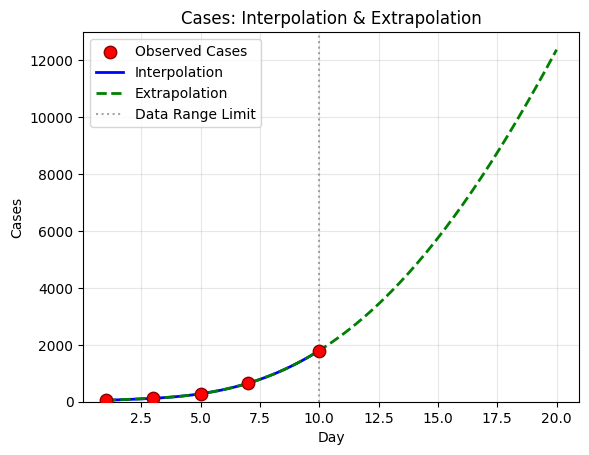

In [68]:
x_interp = np.linspace(predictor.days.min(), predictor.days.max(), 100)
x_extrap = np.linspace(predictor.days.min(), 20, 150)

y_interp_cases = predictor.interpolator_cases.evaluate(x_interp)
y_extrap_cases = predictor.interpolator_cases.evaluate(x_extrap)

plt.scatter(predictor.days, predictor.case_data, color='red', s=80,
            label='Observed Cases', zorder=5, edgecolors='darkred')
plt.plot(x_interp, y_interp_cases, 'b-', linewidth=2, label='Interpolation')
plt.plot(x_extrap, y_extrap_cases, 'g--', linewidth=2, label='Extrapolation')
plt.axvline(predictor.days.max(), color='gray', linestyle=':', alpha=0.7,
            label='Data Range Limit')
plt.xlabel('Day')
plt.ylabel('Cases')
plt.title('Cases: Interpolation & Extrapolation')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(bottom=0)

plt.show()

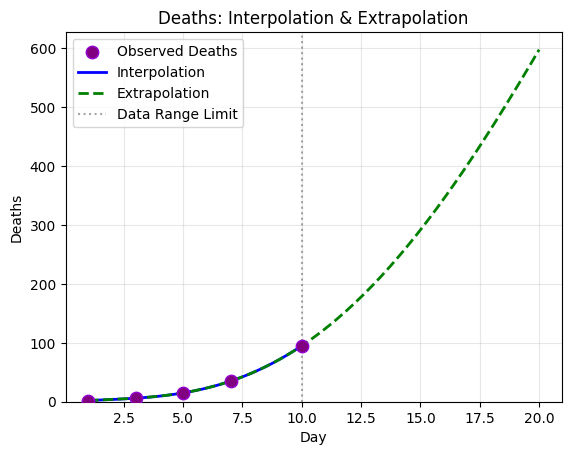

In [70]:
y_interp_deaths = predictor.interpolator_deaths.evaluate(x_interp)
y_extrap_deaths = predictor.interpolator_deaths.evaluate(x_extrap)

plt.scatter(predictor.days, predictor.death_data, color='purple', s=80,
            label='Observed Deaths', zorder=5, edgecolors='darkviolet')
plt.plot(x_interp, y_interp_deaths, 'b-', linewidth=2, label='Interpolation')
plt.plot(x_extrap, y_extrap_deaths, 'g--', linewidth=2, label='Extrapolation')
plt.axvline(predictor.days.max(), color='gray', linestyle=':', alpha=0.7,
            label='Data Range Limit')
plt.xlabel('Day')
plt.ylabel('Deaths')
plt.title('Deaths: Interpolation & Extrapolation')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(bottom=0)

plt.show()

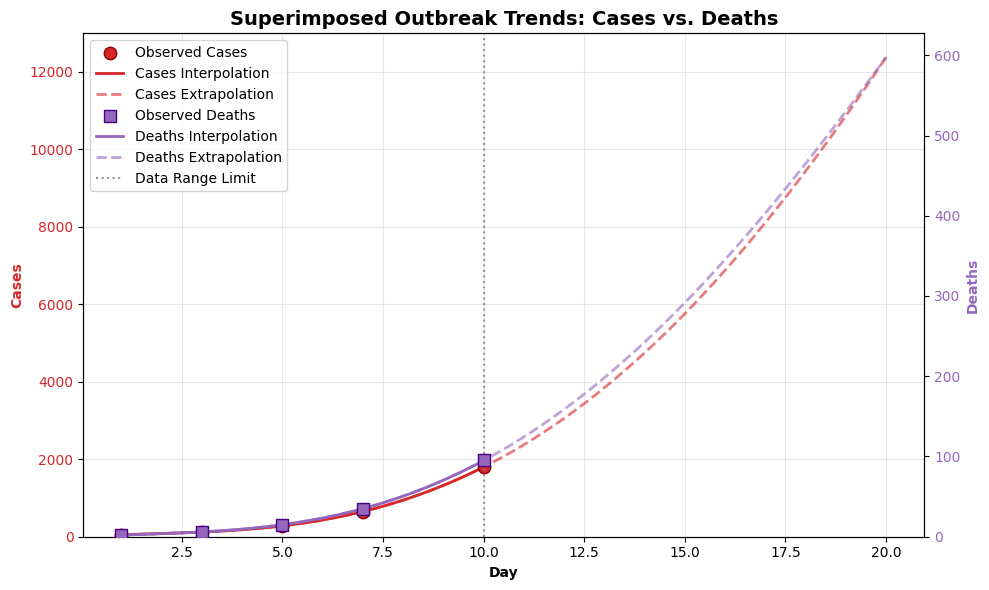

In [72]:
# 1. Setup the figure and primary axis (Cases - Left Side)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Define X ranges for smooth plotting
x_interp = np.linspace(predictor.days.min(), predictor.days.max(), 100)
x_extrap = np.linspace(predictor.days.min(), 20, 150)

# Calculate Y values
y_interp_cases = predictor.interpolator_cases.evaluate(x_interp)
y_extrap_cases = predictor.interpolator_cases.evaluate(x_extrap)
y_interp_deaths = predictor.interpolator_deaths.evaluate(x_interp)
y_extrap_deaths = predictor.interpolator_deaths.evaluate(x_extrap)

# --- PLOT CASES (Left Axis) ---
color_cases = 'tab:red'
ax1.set_xlabel('Day', fontweight='bold')
ax1.set_ylabel('Cases', color=color_cases, fontweight='bold')
# Observed Cases
ax1.scatter(predictor.days, predictor.case_data, color=color_cases, s=80, 
            label='Observed Cases', zorder=5, edgecolors='darkred')
# Interpolation (Solid)
ax1.plot(x_interp, y_interp_cases, color=color_cases, linestyle='-', 
         linewidth=2, label='Cases Interpolation')
# Extrapolation (Dashed)
ax1.plot(x_extrap, y_extrap_cases, color=color_cases, linestyle='--', 
         linewidth=2, alpha=0.6, label='Cases Extrapolation')
ax1.tick_params(axis='y', labelcolor=color_cases)
ax1.set_ylim(bottom=0)

# --- PLOT DEATHS (Right Axis) ---
# Create a second axes that shares the same x-axis
ax2 = ax1.twinx()  

color_deaths = 'tab:purple'
ax2.set_ylabel('Deaths', color=color_deaths, fontweight='bold')
# Observed Deaths
ax2.scatter(predictor.days, predictor.death_data, color=color_deaths, s=80, marker='s',
            label='Observed Deaths', zorder=5, edgecolors='indigo')
# Interpolation (Solid)
ax2.plot(x_interp, y_interp_deaths, color=color_deaths, linestyle='-', 
         linewidth=2, label='Deaths Interpolation')
# Extrapolation (Dashed)
ax2.plot(x_extrap, y_extrap_deaths, color=color_deaths, linestyle='--', 
         linewidth=2, alpha=0.6, label='Deaths Extrapolation')
ax2.tick_params(axis='y', labelcolor=color_deaths)
ax2.set_ylim(bottom=0)

# --- FORMATTING ---
# Add a vertical line for the data range limit
plt.axvline(predictor.days.max(), color='gray', linestyle=':', alpha=0.8, 
            label='Data Range Limit')

plt.title('Superimposed Outbreak Trends: Cases vs. Deaths', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()

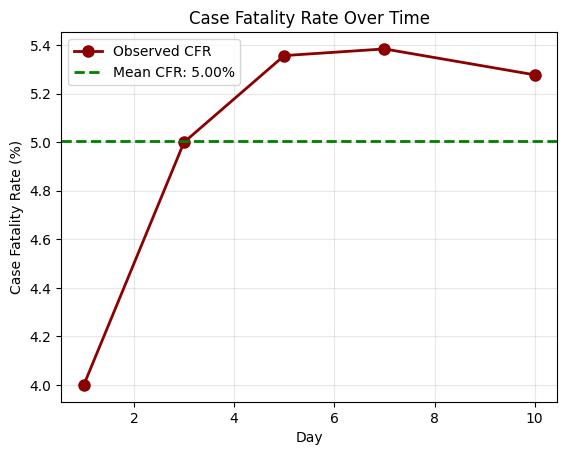

In [71]:
# Plot 4: Case Fatality Rate (CFR)
case_fatality_rate = (predictor.death_data / predictor.case_data) * 100.0

plt.plot(predictor.days, case_fatality_rate, 'o-',
         color='darkred', linewidth=2, markersize=8, label='Observed CFR')
plt.axhline(np.mean(case_fatality_rate), color='green', linestyle='--',
            linewidth=2, label=f'Mean CFR: {np.mean(case_fatality_rate):.2f}%')
plt.xlabel('Day')
plt.ylabel('Case Fatality Rate (%)')
plt.title('Case Fatality Rate Over Time')
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

## Comprehensive Results Summary
This code cell prints a textual report summarizing results.

In [ ]:
# 12. COMPREHENSIVE RESULTS SUMMARY
# ---------------------------------

print("\n" + "="*70)
print("COMPREHENSIVE OUTBREAK PREDICTION REPORT")
print("="*70)

print("\n1. DATA SUMMARY")
print("-"*70)
print(f"Total observed data points: {len(predictor.days)}")
print(f"Time period: Days {predictor.days.min():.0f} to {predictor.days.max():.0f}")
print(f"Total cases (observed): {predictor.case_data.sum():.0f}")
print(f"Total deaths (observed): {predictor.death_data.sum():.0f}")
print(f"Overall Case Fatality Rate: {(predictor.death_data.sum()/predictor.case_data.sum()*100):.2f}%")

print("\n2. INTERPOLATION RESULTS")
print("-"*70)
print(f"Days interpolated: {len(days_to_interpolate)}")
interpolated_total = np.sum(predictor.interpolate(days_to_interpolate, 'cases'))
print(f"Estimated total cases in interpolated days: {interpolated_total:.0f}")

print("\n3. EXTRAPOLATION RESULTS")
print("-"*70)
print(f"Days extrapolated: {len(future_days)}")
future_predictions = predictor.extrapolate(future_days, 'cases')
print(f"Predicted total cases in future days: {future_predictions.sum():.0f}")
print(f"Maximum predicted daily cases: {future_predictions.max():.0f}")
print(f"Day of maximum predicted cases: Day {future_days[np.argmax(future_predictions)]:.0f}")

print("\n4. GROWTH ANALYSIS")
print("-"*70)
initial_cases = predictor.case_data[0]
final_cases = predictor.case_data[-1]
growth_factor = final_cases / initial_cases
days_elapsed = predictor.days[-1] - predictor.days[0]
doubling_time = days_elapsed * np.log(2) / np.log(growth_factor)

print(f"Growth factor (initial to final): {growth_factor:.2f}x")
print(f"Days elapsed between first and last point: {days_elapsed:.0f} days")
print(f"Estimated doubling time (approx.): {doubling_time:.2f} days")

print("\n5. ERROR ASSESSMENT (BASED ON SYNTHETIC TRUTH)")
print("-"*70)
print(f"Mean Absolute Error (MAE): {mae:.2f} cases")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} cases")
print(f"Average Relative Error: {np.mean(rel_errors)*100:.2f}%")

print("\n6. QUALITATIVE RECOMMENDATIONS")
print("-"*70)
print("✓ Interpolation Inside Observed Range (High Confidence)")
print("  - Use for estimating missing days between observed data points.")
print("  - Errors and error bounds are relatively small and stable.")

print("\n⚠ Short-Term Extrapolation (Moderate Confidence)")
print("  - Reasonable up to a few days beyond the last observed day.")
print("  - Error bounds increase but may still be acceptable for rough forecasting.")

print("\n✗ Long-Term Extrapolation (Low Confidence)")
print("  - Not recommended far beyond the observed time range.")
print("  - Real outbreaks change dynamically and are not purely polynomial.")

print("\n" + "="*70)
print("END OF REPORT")
print("="*70)